# Rydberg Pair Potentials Under External Fields

Experimental parameters have to be chosen carefully to maintain the Rydberg blockade as discussed in S. de Léséleuc, S. Weber, V. Lienhard, D. Barredo, H.P. Büchler, T. Lahaye, A. Browaeys, “Accurate mapping of multilevel Rydberg atoms on interacting spin-1/2 particles for the quantum simulation of Ising models”, [Phys. Rev. Lett. 120, 113602 (2018)](http://doi.org/10.1103/PhysRevLett.120.113602). Here we reproduce the result shown in Fig. 2c,d that the Rydberg blockade of $nD$-states can be broken by suprisingly small electric fields, i.e. by fields which cause only a tiny single-atom Stark shift. The parameter dependence of the electric field sensitivity can be studied by rerunning the Jupyter notebook for different interaction angles, external magnetic fields, or principal quantum numbers. The [Jupyter notebook](https://github.com/pairinteraction/pairinteraction/blob/master/doc/sphinx/examples_python/pair_potential_efield_sensitivity.ipynb) and the final [Python script](https://github.com/pairinteraction/pairinteraction/blob/master/doc/sphinx/examples_python/pair_potential_efield_sensitivity.py) are available on GitHub.



As described in the [introduction](introduction.ipynb), we start our code with some preparations. We will make use of pairinteraction's parallel capacities which is why we load the `multiprocessing` module if supported by the operating system (in Windows, the module only works with methods defined outside an IPython notebook).

In [1]:
%matplotlib inline

# Arrays
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from cycler import cycler

# Operating system interfaces
import os, sys

# Parallel computing
if sys.platform != "win32":
    from multiprocessing import Pool

# pairinteraction :-)
from pairinteraction import pireal as pi

# Create cache for matrix elements
if not os.path.exists("./cache"):
    os.makedirs("./cache")
cache = pi.MatrixElementCache("./cache")

We begin by defining some constants of our calculation: the spatial separations of the Rydberg atoms for which we want to evaluate the pair potential, a zero and non-zero electric field, the external magnetic field, and a generic interaction angle.  The units of the respective quantities are given as comments.

In [2]:
distances = np.linspace(14, 4, 200)  # µm
efields = [0, 0.020]  # V/cm
bfield = 6.9  # Gauss
angle = 78 * np.pi / 180  # rad

Now, we use pairinteraction's `StateOne` class to define the single-atom state $\left|61d_{3/2},m_j=3/2\right\rangle$ of a Rubidium atom.

In [3]:
state_one = pi.StateOne("Rb", 61, 2, 1.5, 1.5)

Next, we define how to set up the single atom system.  We do this using a function, so we can easily create systems with the electric field as a parameter.  Inside the function, we create a new system by passing the `state_one` and the cache directory we created to `SystemOne`.

To limit the size of the basis, we have to choose cutoffs on states which couple to `state_one`.  This is done by means of the `restrict...` functions in `SystemOne`.

We set the external fields to point in $z$-direction.

In [4]:
def setup_system_one(efield):
    system_one = pi.SystemOne(state_one.getSpecies(), cache)
    system_one.restrictEnergy(state_one.getEnergy() - 30, state_one.getEnergy() + 30)
    system_one.restrictN(state_one.getN() - 2, state_one.getN() + 2)
    system_one.restrictL(state_one.getL() - 2, state_one.getL() + 2)
    system_one.setBfield([0, 0, bfield])
    system_one.setEfield([0, 0, efield])
    return system_one

To investigate the $\left|61d_{3/2},m_j=3/2;61d_{3/2},m_j=3/2\right\rangle$ pair state, we combine the same single-atom state twice into a pair state using `StateTwo`.

In [5]:
state_two = pi.StateTwo(state_one, state_one)

Akin to the single atom system, we now define how to create a two atom system.  We want to parametrize this in terms of the single atom system and the spatial separation.

We compose a `SystemTwo` from two identical `system_one` because we are looking at two identical atoms.  Again, we have to restrict the energy range for coupling.  Then we proceed to set the distance between the two atoms and the interaction angle.

To speed up the calculation, we tell pairinteraction that this system will have some symmetries.

In [6]:
def setup_system_two(system_one, distance):
    system_two = pi.SystemTwo(system_one, system_one, cache)
    system_two.restrictEnergy(state_two.getEnergy() - 1, state_two.getEnergy() + 1)
    system_two.setDistance(distance)
    system_two.setAngle(angle)
    system_two.setConservedParityUnderPermutation(pi.ODD)
    return system_two

Now, we use the definitions from above to compose our calculation. Since we are only interested in pair potential curves close to the investigated pair state, we further restrict the energy range after diagonalizing the two atom system.

In [7]:
def getSystems(distance, system_one, fieldshift):
    # Set up two atom system
    system_two = setup_system_two(system_one, distance)
    system_two.diagonalize(1e-3)

    # Restrict the calculated eigenenergies
    system_two.restrictEnergy(fieldshift - 0.015, fieldshift + 0.015)
    system_two.buildHamiltonian()  # has to be called to apply the new restriction in energy
    return system_two

Finally, we run the calculations for the given values of the electric field. The method `getConnections` tells which eigenenergies are adiabatically connected and make up pair potential curves. Using `matplotlib`, we plot the resulting pair potential curves which are colored accordingly to the overlap with the investigated pair state.

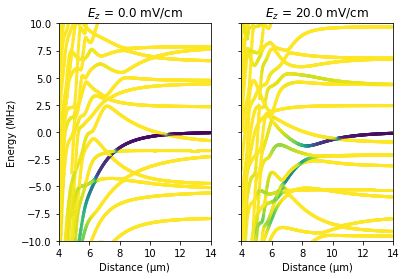

In [8]:
fig = plt.figure()
axes = [fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2)]

for ax, efield in zip(axes, efields):
    # Set up one atom systems
    system_one = setup_system_one(efield)
    system_one.diagonalize(1e-3)
    fieldshift = (
        2
        * system_one.getHamiltonian().diagonal()[
            system_one.getBasisvectorIndex(state_one)
        ]
    )

    # Get diagonalized two atom systems
    def fct(distance):
        return getSystems(distance, system_one, fieldshift)

    if sys.platform != "win32":
        with Pool() as pool:
            systems_two = pool.map(fct, distances)
    else:
        systems_two = list(map(fct, distances))

    # Plot pair potentials
    ax.set_title(rf"$E_z$ = ${efield * 1e3}$ mV/cm")
    ax.set_xlabel(r"Distance (µm)")
    ax.set_xlim(np.min(distances), np.max(distances))
    ax.set_ylim(-10, 10)

    for i1, i2 in zip(range(0, len(systems_two) - 1), range(1, len(systems_two))):
        c1, c2 = np.array(systems_two[i1].getConnections(systems_two[i2], 0.001))
        segment_distances = [distances[i1], distances[i2]]
        segment_energies = (
            np.array(
                [
                    systems_two[i1].getHamiltonian().diagonal()[c1],
                    systems_two[i2].getHamiltonian().diagonal()[c2],
                ]
            )
            - fieldshift
        ) * 1e3  # MHz
        segment_overlap = np.mean(
            [
                systems_two[i1].getOverlap(state_two)[c1],
                systems_two[i2].getOverlap(state_two)[c2],
            ],
            axis=0,
        )
        segment_color = plt.cm.viridis_r(segment_overlap)
        ax.set_prop_cycle(cycler("color", segment_color))
        ax.plot(segment_distances, segment_energies, lw=3)

axes[0].set_ylabel(r"Energy (MHz)")
axes[1].set_yticklabels([]);